# HW5:

В домашньому завданні до даного модулю ви потренуєтесь робити тестове завдання для влаштування на роботу. 
За даними акселерометра з мобільного телефону потрібно класифікувати, якою діяльністю займається людина: йде, стоїть, біжить чи йде по сходах. 
Знайти датасет ви можете за посиланням....

Використайте алгоритми SVM та випадковий ліс з бібліотеки scikit-learn. Як характеристики можете брати показники з акселерометра, проте щоб покращити результати роботи алгоритмів, спочатку можна підготувати наш датасет і розрахувати часові ознаки (time domain features). Більше ці характеристики описані в даній статті.

Порівняйте результати роботи обох алгоритмів на різних фічах та різні моделі між собою.

In [4]:
from itertools import combinations
import math as m
from pathlib import Path
import pickle
from typing import Union

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.svm import SVC
import tsfresh  # poetry add tsfresh
%matplotlib inline

## Data preparation:

In [5]:
def read_from_csvfile(file: Path) -> pd.DataFrame:
    """Read content from csv-file and return dataframe from content."""
    df = pd.read_csv(file)
    
    return df

In [6]:
df = pd.DataFrame()
classification_human_activity = {}

- https://www.geeksforgeeks.org/different-ways-to-create-pandas-dataframe/
- https://pandas.pydata.org/docs/reference/api/pandas.concat.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.std.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.skew.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.kurt.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.var.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.idxmax.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.idxmin.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html
- https://stackoverflow.com/questions/53177327/how-to-compute-shannon-entropy-of-information-from-a-pandas-dataframe
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html

In [7]:
def get_statistical_features(y: str, df: pd.DataFrame) -> pd.DataFrame:
    # y - type real data; df - sample data. 
    if y not in classification_human_activity:
        classification_human_activity[y] = len(classification_human_activity)

    data = {'activity': [classification_human_activity[y]]}

    [data.update({
                  f'max_{col[-1]}':[max(df[col])],
                  f'min_{col[-1]}':[min(df[col])],
                  f'mean_{col[-1]}':[df[col].mean(axis=0)],
                  f'med_{col[-1]}':[df[col].median(axis=0)],  # median
                  f'std_{col[-1]}':[df[col].std(axis=0)],  # Standard deviation
                  f'skew_{col[-1]}':[df[col].skew(axis=0)],  # skewness
                  f'kurt_{col[-1]}':[df[col].kurt(axis=0)],  # kurtosis
                  f'var_{col[-1]}':[df[col].var(axis=0)],  # variance
                  f'idxmax_{col[-1]}':[df[col].idxmax(axis=0)],  # index of first occurrence of maximum over requested axis
                  f'idxmin_{col[-1]}':[df[col].idxmin(axis=0)],  # index of first occurrence of minimum over requested axis
                  }) 
        for col in df.columns]

    [data.update({
                  f'rmse_{col[-1]}':[mean_squared_error(df[col], [data[f'mean_{col[-1]}'] for __ in range(df.shape[0])], squared=False)],  # variance# Root Mean Square Error
                  f'mae_{col[-1]}':[mean_absolute_error(df[col], [data[f'mean_{col[-1]}'] for __ in range(df.shape[0])])],  # mean absolute error
                  }) 
        for col in df.columns]
    
    df_f = pd.DataFrame(data)
    
    return df_f

In [91]:
def get_data_to_dafaframe(path: Union[str, Path], df: pd.DataFrame, get_features: callable) -> pd.DataFrame:
    path = Path(path)
    if not path.is_dir() or not path.exists():
        return None
    
    for file_system_object in path.iterdir():
        if file_system_object.is_dir():
            df = get_data_to_dafaframe(file_system_object, df, get_features)
            
        elif file_system_object.suffix.lower() in ('.csv',):
            df_add = read_from_csvfile(file_system_object)
            df = pd.concat([df, get_features(file_system_object.stem.split('-')[0], df_add)], ignore_index=True)

    return df

In [9]:
def save_prepared_data(df: pd.DataFrame, file_name: str='data_0.bin') -> None:
    with open(file_name, 'wb') as fh:
        pickle.dump(df, fh)


In [10]:
def load_prepared_data(file_name: str='data_0.bin') -> pd.DataFrame:
    with open(file_name, 'rb') as fh:
        df = pickle.load(fh)

    return df

Якщо немає підготовлених даних (data0.bin & data1.bin) - обробляємо знову з сирих

In [11]:
if Path('data0.bin').is_file() and Path('data1.bin').is_file():
    df = load_prepared_data('data1.bin')
    classification_human_activity = load_prepared_data('data0.bin')

else:
    df = get_data_to_dafaframe('data', df, get_statistical_features)
    save_prepared_data(df, 'data1.bin')
    save_prepared_data(classification_human_activity, 'data0.bin')

In [12]:
df.tail(3)

,activity,max_X,min_X,mean_X,med_X,std_X,skew_X,kurt_X,var_X,idxmax_X,...,kurt_Z,var_Z,idxmax_Z,idxmin_Z,rmse_X,mae_X,rmse_Y,mae_Y,rmse_Z,mae_Z
6459,3,8.073248,-4.582502,2.830745,3.447650,3.302172,-0.492919,-0.453013,10.904337,11,...,3.758635,20.366468,27,29,3.246669,2.650009,4.630977,3.314692,4.437069,2.83880
6460,3,9.035717,-6.904877,-0.025219,-0.399831,3.414785,0.284005,0.775833,11.660759,1,...,2.128289,19.916885,1,29,3.357390,2.592356,5.177956,3.986420,4.387823,2.95603
6461,3,8.398860,-6.224924,0.964544,1.376666,2.958615,-0.059084,0.721621,8.753403,20,...,4.863290,39.297190,19,23,2.908887,2.250614,4.252132,3.073357,6.163382,4.05880


Розшифровка позначень типів діяльності

In [13]:
classification_human_activity

{'walking': 0, 'running': 1, 'idle': 2, 'stairs': 3}

In [14]:
if not classification_human_activity.get(0):
    classification_human_activity = {val:key for key, val in classification_human_activity.items()}

classification_human_activity

{0: 'walking', 1: 'running', 2: 'idle', 3: 'stairs'}

In [15]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

In [71]:
X.shape

(6462, 36)

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

(рандомне перемішування даних shuffle=True може помітно впливати на результати співставлення різних алгоритмів, усереднено - орієнтовно достатня точність)

In [16]:
y = y.values

In [17]:
# Робимо вибірки - розділяємо всі дані на групи для тренування, валідаційну та тестову (stratify для рівномірного розподілу за значенням y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y)  # random_state=42
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, stratify=y_test)
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((4329, 36), (1066, 36), (1067, 36), (4329,), (1066,), (1067,))

## SVC Model training

Натренуємо (.fit) модельки (ймовірність - probability)

In [18]:
C = [10**q for q in range(-3, 4)]  # 7
gamma = [10**g for g in range(-2, 1)]  # 3+
gamma.append('auto')
degree = [d for d in range(2,7)]  # 6

models_svc_linear = {f'linear>C={coef_C}':SVC(kernel='linear', C=coef_C, probability=True).fit(X_train, y_train) for coef_C in C}
models_svc_rbf = {f'rbf>C={coef_C};g={coef_g}': SVC(kernel='rbf', C=coef_C, gamma=coef_g, probability=True).fit(X_train, y_train) for coef_C in C for coef_g in gamma}
models_svc_poly = {f'poly>C={coef_C};d={deg}': SVC(kernel='poly', degree=deg, C=coef_C, probability=True).fit(X_train, y_train) for coef_C in C for deg in degree}

- https://towardsdatascience.com/predict-vs-predict-proba-scikit-learn-bdc45daa5972

## Random Forest Model training
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [19]:
number_of_trees = [2**(trees+1) for trees in range(1, 7)]  # 6
models_RF = {f'RF_n_est={items}':RandomForestClassifier(n_estimators=items).fit(X_train, y_train) for items in number_of_trees}

## Launching models

In [20]:
# для отримання значення моделей за валідаційними/тестовими вибірками і перевіримо узагальнену точність [accuracy_score, f1_score, ]
def run_model(model: Union[SVC, RandomForestClassifier], new_data: pd.DataFrame, real_result: pd.Series) -> list:
    y_valid_pred = model.predict_proba(new_data)  # [:, 2]  # probability for classification_human_activity[2] - для 'idle'
    # визначаємо клас(и) з результатів за максимальною ймовірністю зі значень для всіх класів:
    from_model_by_max = pd.DataFrame(y_valid_pred).idxmax(1).values  
    m1 = accuracy_score(real_result, from_model_by_max)
    m2 = f1_score(real_result, from_model_by_max, average='weighted')  # average=None - for each class
    
    return [m1, m2]  # metric results

In [21]:
# для прорахунку результатів перевірки за моделями (валідації/тесту...)
def get_model_results(
                      X_valid: pd.DataFrame, 
                      y_valid: pd.Series, 
                      sets_of_models: list,
                      ) -> pd.DataFrame:
    valid_results = {}
    for model_set in sets_of_models:
        models = {mark:run_model(model, X_valid, y_valid) for mark, model in model_set.items()} if model_set else {}
        valid_results.update(models)

    valid_results = pd.DataFrame(valid_results).T

    valid_results.columns = ['accuracy_score', 'f1_score', ]

    return valid_results

In [22]:
# Порахуємо результати узагальнених точностей за різними моделями для різних вибірок
train_results = get_model_results(X_train, y_train, [models_svc_linear, models_svc_rbf, models_svc_poly, models_RF])
valid_results = get_model_results(X_valid, y_valid, [models_svc_linear, models_svc_rbf, models_svc_poly, models_RF])
test_results = get_model_results(X_test, y_test, [models_svc_linear, models_svc_rbf, models_svc_poly, models_RF])

## Comparison of results

In [23]:
# для порівняння результатів візуально
def show_compare_accuracy_scatter(x: pd.Series, data: pd.DataFrame) -> None:
    plt.figure(figsize=(int(x.shape[0]/4), 6))
    [ax := sns.scatterplot(x=x, y=ac, data=data, label=ac) for ac in valid_results.columns]

    plt.xticks(rotation=85)
    plt.ylabel('accuracy value', fontsize='small', color='midnightblue')
    plt.grid()
    ax.legend()
    plt.show()

- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html
- https://www.geeksforgeeks.org/how-to-sort-pandas-dataframe/

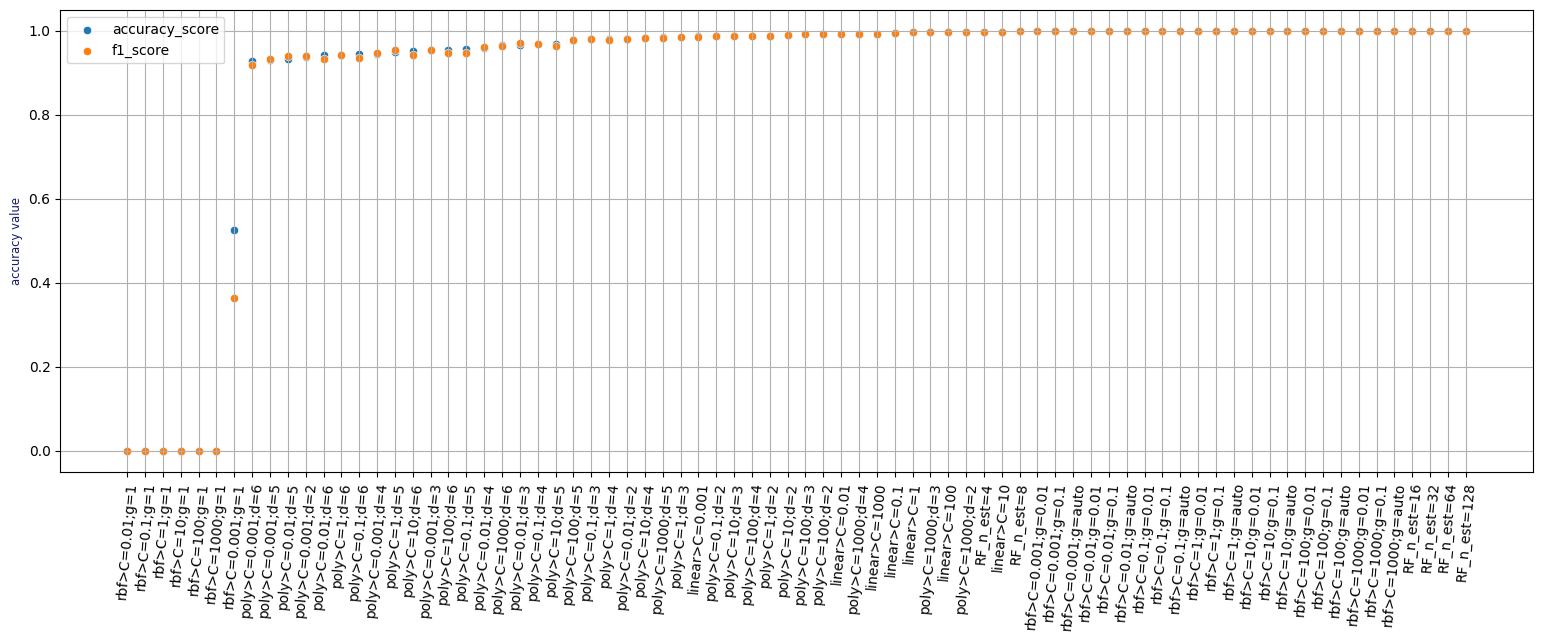

In [24]:
# Порівняння точності за тренувальними вибірками для різних моделей
train_results = train_results.sort_values(by=['accuracy_score', 'f1_score'])
show_compare_accuracy_scatter(x=train_results.index, data=train_results)

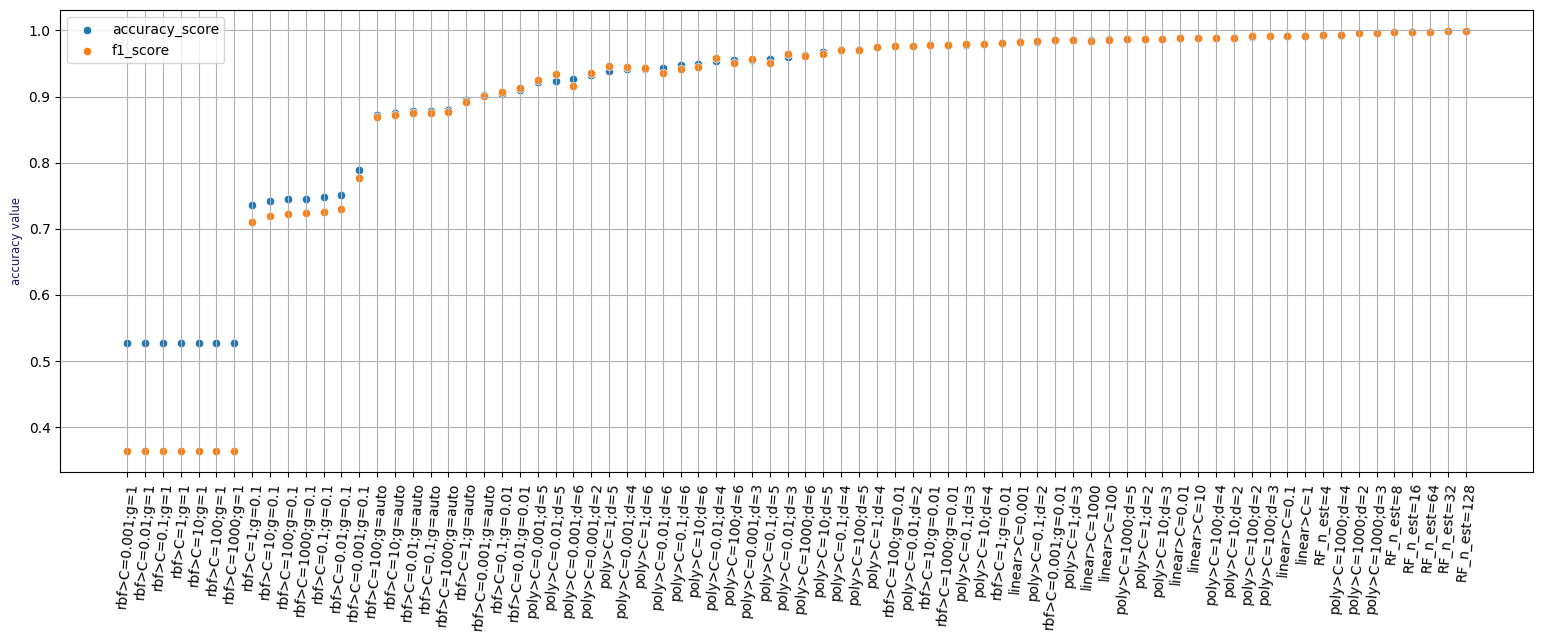

In [25]:
# Порівняння точності за валідаційними вибірками для різних моделей
valid_results = valid_results.sort_values(by=['accuracy_score', 'f1_score'])
show_compare_accuracy_scatter(x=valid_results.index, data=valid_results)

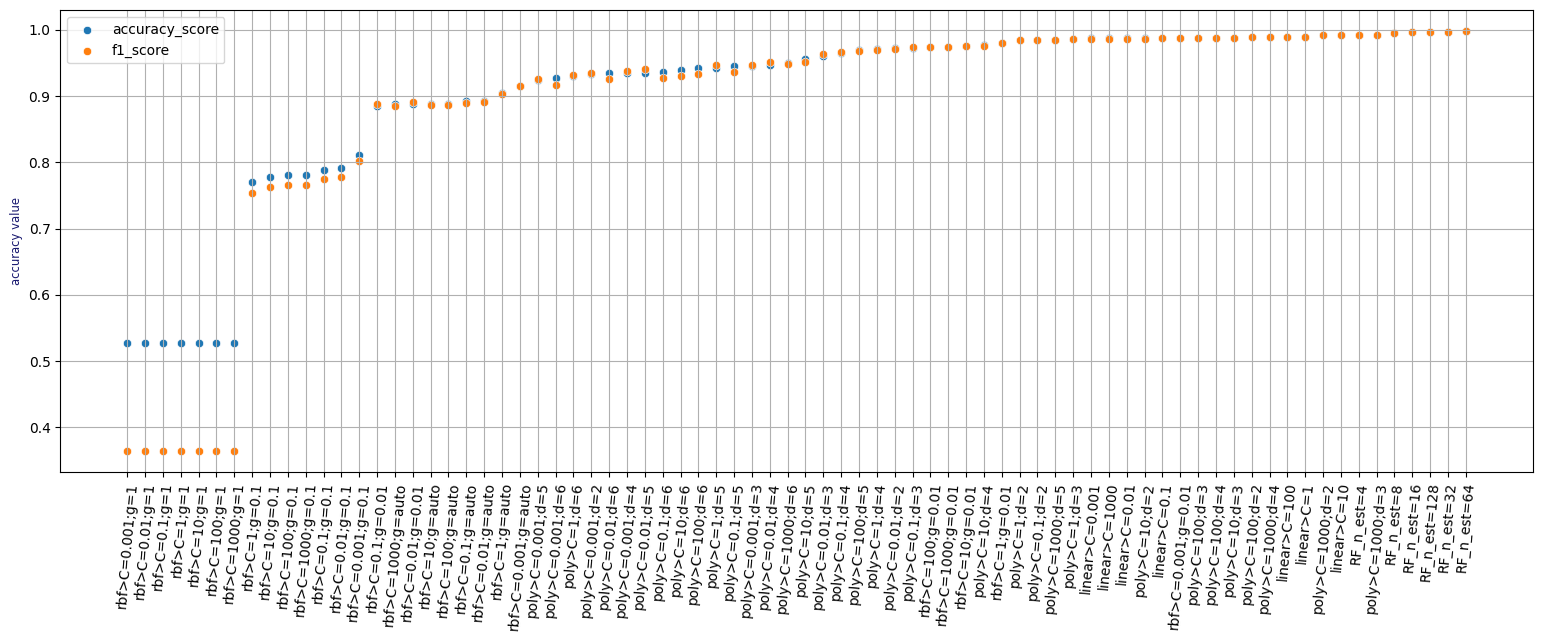

In [26]:
# Порівняння точності за тестовими вибірками для різних моделей
test_results = test_results.sort_values(by=['accuracy_score', 'f1_score'])
show_compare_accuracy_scatter(x=test_results.index, data=test_results)

In [27]:
train_results[train_results['accuracy_score'] >= 0.995]

,accuracy_score,f1_score
linear>C=0.1,0.995611,0.995546
linear>C=1,0.996535,0.996483
poly>C=1000;d=3,0.996766,0.996721
linear>C=100,0.997690,0.997661
poly>C=1000;d=2,0.997921,0.997890
RF_n_est=4,0.998614,0.998596
linear>C=10,0.998614,0.998608
RF_n_est=8,0.999307,0.999303
rbf>C=0.001;g=0.01,1.000000,1.000000
rbf>C=0.001;g=0.1,1.000000,1.000000


In [28]:
# Подивимося на 'найкращі' моделі за результатом роботи моделей для різних вибірок
# valid_results.iloc[-4:], test_results.iloc[-4:]

In [29]:
""" Результати за попередніми розрахунками без моделей Random Forest
Варіант з перемішуванням 1:
(                 accuracy_score  f1_score
 linear>C=0.1           0.993433  0.993181
 linear>C=1             0.993433  0.993181
 poly>C=1000;d=2        0.995310  0.995124
 poly>C=1000;d=3        0.997186  0.997121,
                  accuracy_score  f1_score
 linear>C=1             0.996251  0.996113
 poly>C=1000;d=2        0.996251  0.996185
 poly>C=1000;d=3        0.996251  0.996185
 linear>C=100           0.997188  0.997164)

 Варіант з перемішуванням 2:
 (                 accuracy_score  f1_score
 linear>C=1000           0.99531  0.995094
 linear>C=1              0.99531  0.995242
 linear>C=0.1            0.99531  0.995373
 poly>C=1000;d=2         0.99531  0.995373,
                  accuracy_score  f1_score
 linear>C=100           0.993440  0.993282
 linear>C=10            0.994377  0.994377
 poly>C=1000;d=3        0.997188  0.997167
 poly>C=1000;d=2        1.000000  1.000000)

Варіант з перемішуванням 3:
(               accuracy_score  f1_score
 linear>C=100         0.993433  0.993381
 linear>C=1000        0.993433  0.993484
 linear>C=1           0.994371  0.994371
 linear>C=10          0.995310  0.995272,
                  accuracy_score  f1_score
 linear>C=1000          0.990628  0.990262
 linear>C=1             0.990628  0.990628
 poly>C=1000;d=3        0.992502  0.992194
 poly>C=1000;d=2        0.996251  0.996203)

 Варіант з перемішуванням 5:
 (                 accuracy_score  f1_score
 linear>C=0.1           0.993433  0.993037
 linear>C=0.01          0.993433  0.993162
 poly>C=1000;d=2        0.994371  0.994086
 linear>C=1             0.995310  0.995198,
                  accuracy_score  f1_score
 poly>C=100;d=3         0.992502  0.992507
 poly>C=100;d=2         0.994377  0.994285
 poly>C=1000;d=3        0.995314  0.995197
 poly>C=1000;d=2        0.997188  0.997118)

Варіант з перемішуванням 7:
(                 accuracy_score  f1_score
 linear>C=10            0.994371  0.994272
 poly>C=1000;d=3        0.994371  0.994369
 linear>C=1             0.995310  0.995183
 poly>C=1000;d=2        0.996248  0.996179,
                  accuracy_score  f1_score
 linear>C=1             0.995314  0.995353
 poly>C=1000;d=2        0.998126  0.998093
 linear>C=100           0.998126  0.998126
 linear>C=10            0.998126  0.998156)
"""


' Результати за попередніми розрахунками без моделей Random Forest\nВаріант з перемішуванням 1:\n(                 accuracy_score  f1_score\n linear>C=0.1           0.993433  0.993181\n linear>C=1             0.993433  0.993181\n poly>C=1000;d=2        0.995310  0.995124\n poly>C=1000;d=3        0.997186  0.997121,\n                  accuracy_score  f1_score\n linear>C=1             0.996251  0.996113\n poly>C=1000;d=2        0.996251  0.996185\n poly>C=1000;d=3        0.996251  0.996185\n linear>C=100           0.997188  0.997164)\n\n Варіант з перемішуванням 2:\n (                 accuracy_score  f1_score\n linear>C=1000           0.99531  0.995094\n linear>C=1              0.99531  0.995242\n linear>C=0.1            0.99531  0.995373\n poly>C=1000;d=2         0.99531  0.995373,\n                  accuracy_score  f1_score\n linear>C=100           0.993440  0.993282\n linear>C=10            0.994377  0.994377\n poly>C=1000;d=3        0.997188  0.997167\n poly>C=1000;d=2        1.00000

In [30]:
# орієнтовно зважено можна сказати, що серед SVC poly>C=1000;d=2, poly>C=1000;d=3, та linear> одні з найкащих серед лінійних та поліноміальних варіантів
# Розглянемо linear>C=1
first_result = (train_results.loc['linear>C=1'], valid_results.loc['linear>C=1'], test_results.loc['linear>C=1'])
first_result

(accuracy_score    0.996535
 f1_score          0.996483
 Name: linear>C=1, dtype: float64,
 accuracy_score    0.991557
 f1_score          0.991993
 Name: linear>C=1, dtype: float64,
 accuracy_score    0.989691
 f1_score          0.989776
 Name: linear>C=1, dtype: float64)

In [31]:
best_model = models_svc_linear.get('linear>C=1')

In [32]:
X.columns

Index(['max_X', 'min_X', 'mean_X', 'med_X', 'std_X', 'skew_X', 'kurt_X',
       'var_X', 'idxmax_X', 'idxmin_X', 'max_Y', 'min_Y', 'mean_Y', 'med_Y',
       'std_Y', 'skew_Y', 'kurt_Y', 'var_Y', 'idxmax_Y', 'idxmin_Y', 'max_Z',
       'min_Z', 'mean_Z', 'med_Z', 'std_Z', 'skew_Z', 'kurt_Z', 'var_Z',
       'idxmax_Z', 'idxmin_Z', 'rmse_X', 'mae_X', 'rmse_Y', 'mae_Y', 'rmse_Z',
       'mae_Z'],
      dtype='object')

In [33]:
data = pd.DataFrame(best_model.coef_)
data.columns = X.columns
data = data.abs()
data = data.iloc[-1].sort_values()
biggest = data[data.values >= 0.5*data.max()].index
biggest  # оберемо 'найважливіші' фічі серед усіх:

Index(['var_Z', 'max_Y', 'med_Y', 'mean_Z', 'med_Z', 'mean_Y', 'min_Z',
       'min_Y'],
      dtype='object')

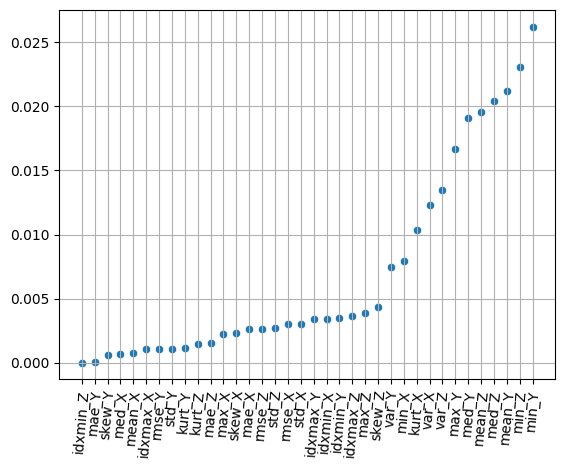

In [34]:
plt.figure()
sns.scatterplot(x=data.index, y=data.values, data=data)
plt.xticks(rotation=85)
plt.grid()
plt.show()

In [35]:
X = X.filter(items=[col for col in biggest])
X.head(3)

,var_Z,max_Y,med_Y,mean_Z,med_Z,mean_Y,min_Z,min_Y
0,46.706543,-1.470040,-10.249578,-0.793758,-0.938527,-9.659965,-14.695610,-17.980455
1,92.547549,-0.311246,-9.866505,0.218830,-1.781286,-10.444944,-16.223110,-22.443247
2,96.324283,0.311246,-12.035652,-2.173296,-1.072602,-11.915463,-25.182213,-27.140670


In [36]:
# Робимо вибірки - розділяємо лише 'важливіші' дані на групи для тренування, валідаційну та тестову
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y)  # random_state=42
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, stratify=y_test)
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((4329, 8), (1066, 8), (1067, 8), (4329,), (1066,), (1067,))

## Повторимо створення та оцінку моделей для лише за 'найвагомішими' параметрами

In [37]:
# C = [10**q for q in range(-3, 4)]  # 7
# gamma = [10**g for g in range(-2, 1)]  # 3+
# gamma.append('auto')
# degree = [d for d in range(2,7)]  # 6

models_svc_linear = {f'linear>C={coef_C}':SVC(kernel='linear', C=coef_C, probability=True).fit(X_train, y_train) for coef_C in C}
models_svc_rbf = {f'rbf>C={coef_C};g={coef_g}': SVC(kernel='rbf', C=coef_C, gamma=coef_g, probability=True).fit(X_train, y_train) for coef_C in C for coef_g in gamma}
models_svc_poly = {f'poly>C={coef_C};d={deg}': SVC(kernel='poly', degree=deg, C=coef_C, probability=True).fit(X_train, y_train) for coef_C in C for deg in degree}

In [38]:
# number_of_trees = [2**(trees+1) for trees in range(1, 7)]  # 6
models_RF = {f'RF_n_est={items}':RandomForestClassifier(n_estimators=items).fit(X_train, y_train) for items in number_of_trees}

In [39]:
# Порахуємо результати узагальнених точностей за новими моделями для різних вибірок
train_results = get_model_results(X_train, y_train, [models_svc_linear, models_svc_rbf, models_svc_poly, models_RF])
valid_results = get_model_results(X_valid, y_valid, [models_svc_linear, models_svc_rbf, models_svc_poly, models_RF])
test_results = get_model_results(X_test, y_test, [models_svc_linear, models_svc_rbf, models_svc_poly, models_RF])

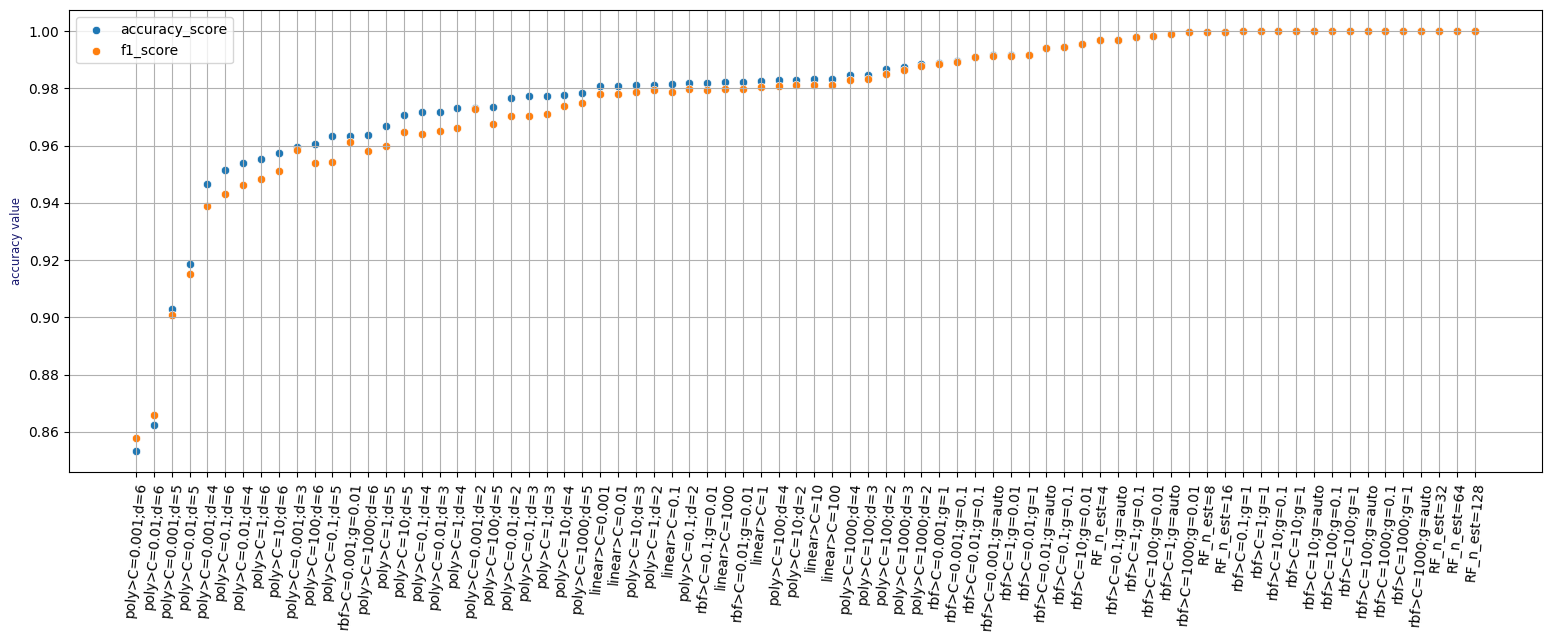

In [40]:
# Порівняння точності за тренувальними вибірками для різних моделей
train_results = train_results.sort_values(by=['accuracy_score', 'f1_score'])
show_compare_accuracy_scatter(x=train_results.index, data=train_results)

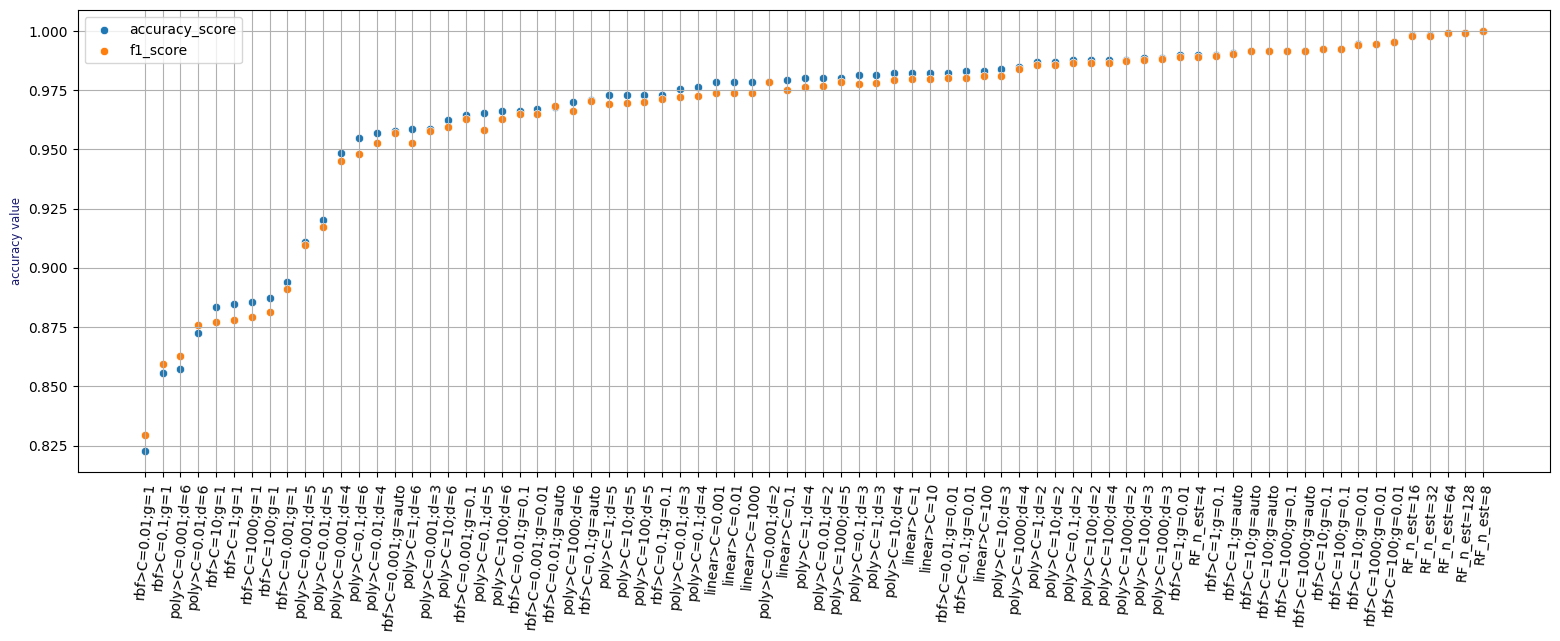

In [41]:
# Порівняння точності за валідаційними вибірками для різних моделей
valid_results = valid_results.sort_values(by=['accuracy_score', 'f1_score'])
show_compare_accuracy_scatter(x=valid_results.index, data=valid_results)

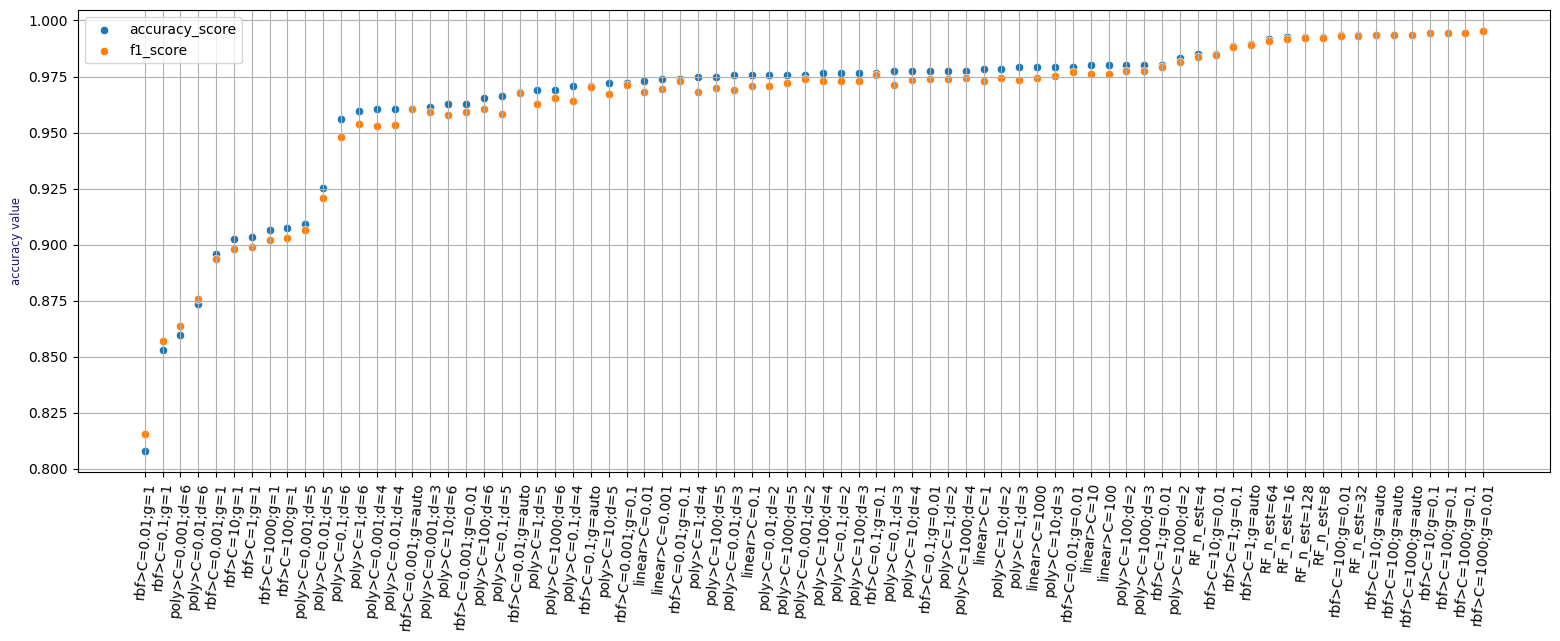

In [42]:
# Порівняння точності за тестовими вибірками для різних моделей
test_results = test_results.sort_values(by=['accuracy_score', 'f1_score'])
show_compare_accuracy_scatter(x=test_results.index, data=test_results)

In [43]:
train_results[train_results['accuracy_score'] >= 0.981].index

Index(['poly>C=10;d=3', 'poly>C=1;d=2', 'linear>C=0.1', 'poly>C=0.1;d=2',
       'rbf>C=0.1;g=0.01', 'linear>C=1000', 'rbf>C=0.01;g=0.01', 'linear>C=1',
       'poly>C=100;d=4', 'poly>C=10;d=2', 'linear>C=10', 'linear>C=100',
       'poly>C=1000;d=4', 'poly>C=100;d=3', 'poly>C=100;d=2',
       'poly>C=1000;d=3', 'poly>C=1000;d=2', 'rbf>C=0.001;g=1',
       'rbf>C=0.001;g=0.1', 'rbf>C=0.01;g=0.1', 'rbf>C=0.001;g=auto',
       'rbf>C=1;g=0.01', 'rbf>C=0.01;g=1', 'rbf>C=0.01;g=auto',
       'rbf>C=0.1;g=0.1', 'rbf>C=10;g=0.01', 'RF_n_est=4', 'rbf>C=0.1;g=auto',
       'rbf>C=1;g=0.1', 'rbf>C=100;g=0.01', 'rbf>C=1;g=auto',
       'rbf>C=1000;g=0.01', 'RF_n_est=8', 'RF_n_est=16', 'rbf>C=0.1;g=1',
       'rbf>C=1;g=1', 'rbf>C=10;g=0.1', 'rbf>C=10;g=1', 'rbf>C=10;g=auto',
       'rbf>C=100;g=0.1', 'rbf>C=100;g=1', 'rbf>C=100;g=auto',
       'rbf>C=1000;g=0.1', 'rbf>C=1000;g=1', 'rbf>C=1000;g=auto',
       'RF_n_est=32', 'RF_n_est=64', 'RF_n_est=128'],
      dtype='object')

In [44]:
# Подивимося на 'найкращі' моделі за результатом роботи моделей для різних вибірок
valid_results.iloc[-6:], test_results.iloc[-6:]

(                  accuracy_score  f1_score
 rbf>C=100;g=0.01        0.995310  0.995269
 RF_n_est=16             0.998124  0.998091
 RF_n_est=32             0.998124  0.998091
 RF_n_est=64             0.999062  0.999054
 RF_n_est=128            0.999062  0.999054
 RF_n_est=8              1.000000  1.000000,
                    accuracy_score  f1_score
 rbf>C=100;g=auto         0.993440  0.993309
 rbf>C=1000;g=auto        0.993440  0.993309
 rbf>C=10;g=0.1           0.994377  0.994306
 rbf>C=100;g=0.1          0.994377  0.994306
 rbf>C=1000;g=0.1         0.994377  0.994369
 rbf>C=1000;g=0.01        0.995314  0.995094)

In [45]:
# Розглянемо поточну версію попередньо вибраної як найкращу linear>C=1
second_result = (train_results.loc['linear>C=1'], valid_results.loc['linear>C=1'], test_results.loc['linear>C=1'])
second_result

(accuracy_score    0.982675
 f1_score          0.980389
 Name: linear>C=1, dtype: float64,
 accuracy_score    0.982176
 f1_score          0.979537
 Name: linear>C=1, dtype: float64,
 accuracy_score    0.978444
 f1_score          0.972918
 Name: linear>C=1, dtype: float64)

In [50]:
# орієнтовний приріст швидкодії моделей при зменшенні з 36 фіч до 7 (= в декілька разів 1+...4+)
(6 * 60 + 5) / (1 * 60 + 50)
(6 * 60 + 30) / (1 * 60 + 41)
(3 * 60 + 54) / (1 * 60 + 57)
(7 * 60 + 24) / (1 * 60 + 46)
(6 * 60 + 51) / (4 * 60 + 19)
(5 * 60 + 59) / (3 * 60 + 20)

1.795

In [47]:
# зменшення точності лінійної моделі 'linear>C=1', орієнтовно - декілька %
for fr, sr in zip(first_result, second_result):
    print(f'''accuracy_score decrease by {round((1 - sr['accuracy_score']/fr['accuracy_score'])*100, 2)} %\n''')
    print(f'''f1_score decrease by {round((1 - sr['f1_score']/fr['f1_score'])*100, 2)} %\n''')

accuracy_score decrease by 1.39 %

f1_score decrease by 1.62 %

accuracy_score decrease by 0.95 %

f1_score decrease by 1.26 %

accuracy_score decrease by 1.14 %

f1_score decrease by 1.7 %



# Time domain features

## Data preparation

- https://en.wikipedia.org/wiki/Signal_magnitude_area

In [48]:
def get_pairwise_correlations(df: pd.DataFrame) -> dict:
    list_comb = list(combinations(list(df.columns), 2))
    return {f'corr_{el[0][-1]}|{el[1][-1]}':[df[[el[0], el[1]]].corr().iloc[0, 1]] for el in list_comb}

In [49]:
def get_time_domain_features(y: str, df: pd.DataFrame) -> pd.DataFrame:
    # y - type real data; df - sample data. 
    if y not in classification_human_activity:
        classification_human_activity[y] = len(classification_human_activity)
    
    df['id'] = 0
    df_features = tsfresh.extract_features(df, column_id='id')

    data = {'activity': [classification_human_activity[y]]}

    [data.update({
                  f'mean_{col[-1]}':[df_features[f'{col}__mean'].values[0]],
                  f'var_{col[-1]}':[df_features[f'{col}__variance'].values[0]],
                  f'std_{col[-1]}':[df_features[f'{col}__standard_deviation'].values[0]],
                  f'med_{col[-1]}':[df_features[f'{col}__median'].values[0]],  # median
                  f'max_{col[-1]}':[df_features[f'{col}__maximum'].values[0]],
                  f'min_{col[-1]}':[df_features[f'{col}__minimum'].values[0]],
                  f'rms_{col[-1]}':[df_features[f'{col}__root_mean_square'].values[0]],
                  f'sma_{col[-1]}':[df_features[f'{col}__sum_values'].values[0]],  # signal magnitude area
                  f'idxmax_{col[-1]}':[df[col].idxmax(axis=0)],  # index of first occurrence of maximum over requested axis
                  f'idxmin_{col[-1]}':[df[col].idxmin(axis=0)],  # index of first occurrence of minimum over requested axis
                  f'energy_{col[-1]}':[df_features[f'{col}__abs_energy'].values[0]],
                  f'entropy_{col[-1]}':[df_features[f'{col}__sample_entropy'].values[0]],
                  f'skew_{col[-1]}':[df_features[f'{col}__skewness'].values[0]],
                  f'kurt_{col[-1]}':[df_features[f'{col}__kurtosis'].values[0]],
                  }) 
        for col in df.columns if col != 'id']

    data.update(get_pairwise_correlations(df[df.columns[:-1]]))  # without 'id'
    
    df_f = pd.DataFrame(data)
    
    return df_f

In [104]:
df = pd.DataFrame()
classification_human_activity = {}
X = pd.DataFrame()

In [105]:
if Path('data2.bin').is_file() and Path('data3.bin').is_file():
    df = load_prepared_data('data3.bin')
    classification_human_activity = load_prepared_data('data2.bin')

else:
    df = get_data_to_dafaframe('data', df, get_time_domain_features)
    save_prepared_data(df, 'data3.bin')
    save_prepared_data(classification_human_activity, 'data2.bin')

In [106]:
df.shape

(6462, 46)

In [108]:
df = df.dropna(axis=1)

In [109]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]
y = y.values

In [110]:
# Робимо вибірки - розділяємо всі дані на групи для тренування, валідаційну та тестову (stratify для рівномірного розподілу за значенням y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y)  # random_state=42
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, stratify=y_test)
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((4329, 42), (1066, 42), (1067, 42), (4329,), (1066,), (1067,))

In [111]:
models_svc_linear = {f'linear>C={coef_C}':SVC(kernel='linear', C=coef_C, probability=True).fit(X_train, y_train) for coef_C in C}
models_svc_rbf = {f'rbf>C={coef_C};g={coef_g}': SVC(kernel='rbf', C=coef_C, gamma=coef_g, probability=True).fit(X_train, y_train) for coef_C in C for coef_g in gamma}
models_svc_poly = {f'poly>C={coef_C};d={deg}': SVC(kernel='poly', degree=deg, C=coef_C, probability=True).fit(X_train, y_train) for coef_C in C for deg in degree}
models_RF = {f'RF_n_est={items}':RandomForestClassifier(n_estimators=items).fit(X_train, y_train) for items in number_of_trees}

In [112]:
# Порахуємо результати узагальнених точностей за різними моделями для різних вибірок
train_results = get_model_results(X_train, y_train, [models_svc_linear, models_svc_rbf, models_svc_poly, models_RF])
valid_results = get_model_results(X_valid, y_valid, [models_svc_linear, models_svc_rbf, models_svc_poly, models_RF])
test_results = get_model_results(X_test, y_test, [models_svc_linear, models_svc_rbf, models_svc_poly, models_RF])

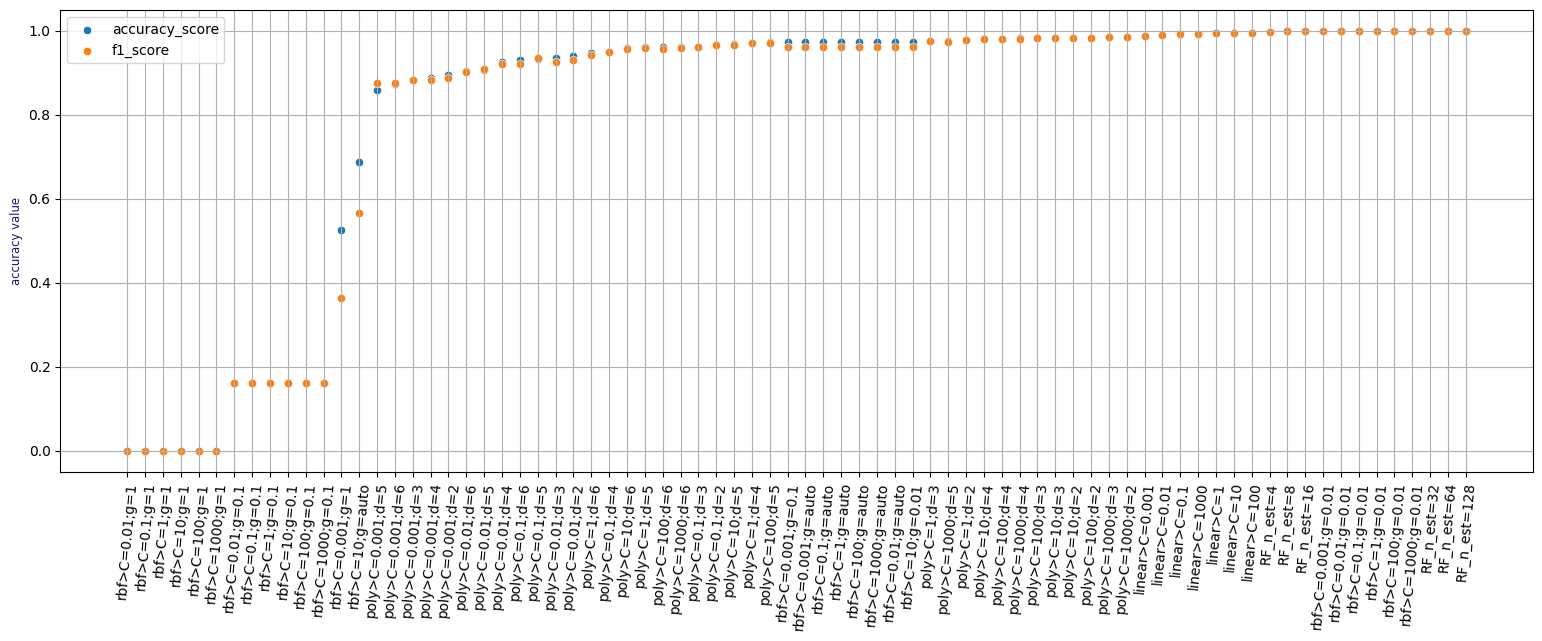

In [113]:
# Порівняння точності за тренувальними вибірками для різних моделей
train_results = train_results.sort_values(by=['accuracy_score', 'f1_score'])
show_compare_accuracy_scatter(x=train_results.index, data=train_results)

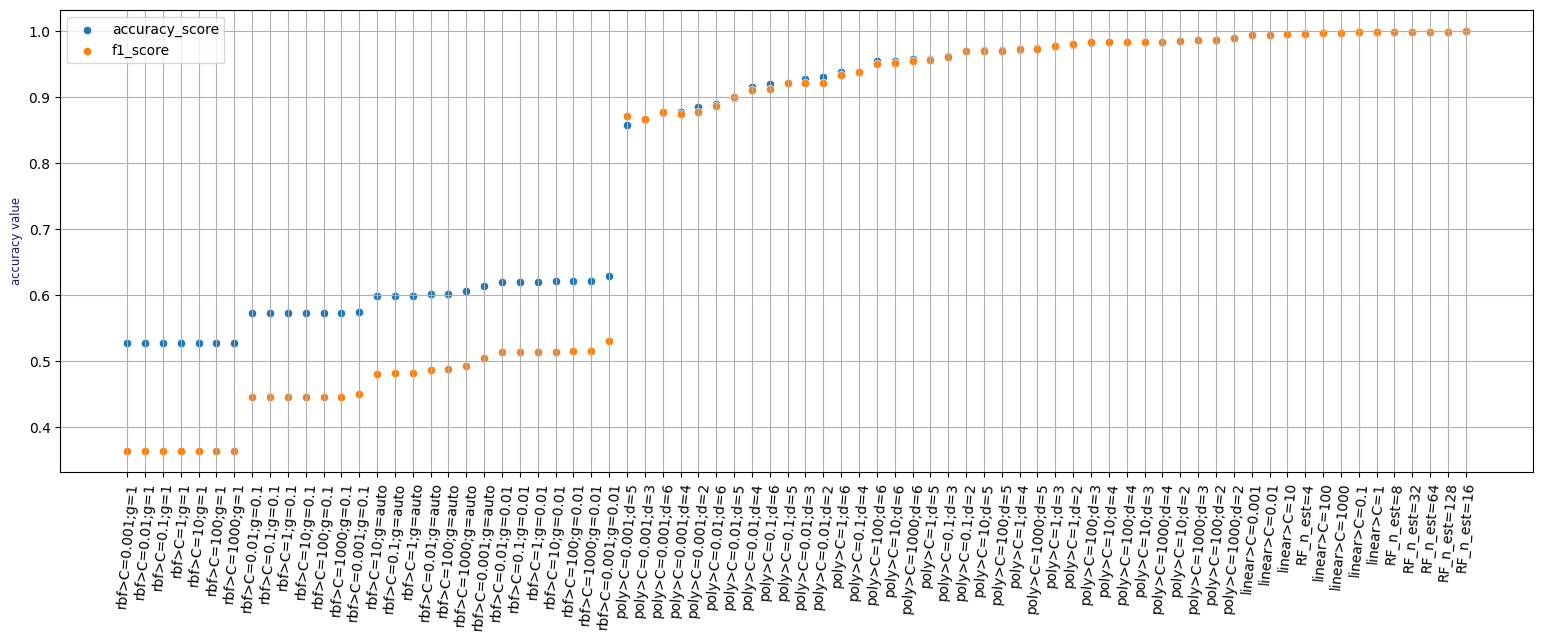

In [114]:
# Порівняння точності за валідаційними вибірками для різних моделей
valid_results = valid_results.sort_values(by=['accuracy_score', 'f1_score'])
show_compare_accuracy_scatter(x=valid_results.index, data=valid_results)

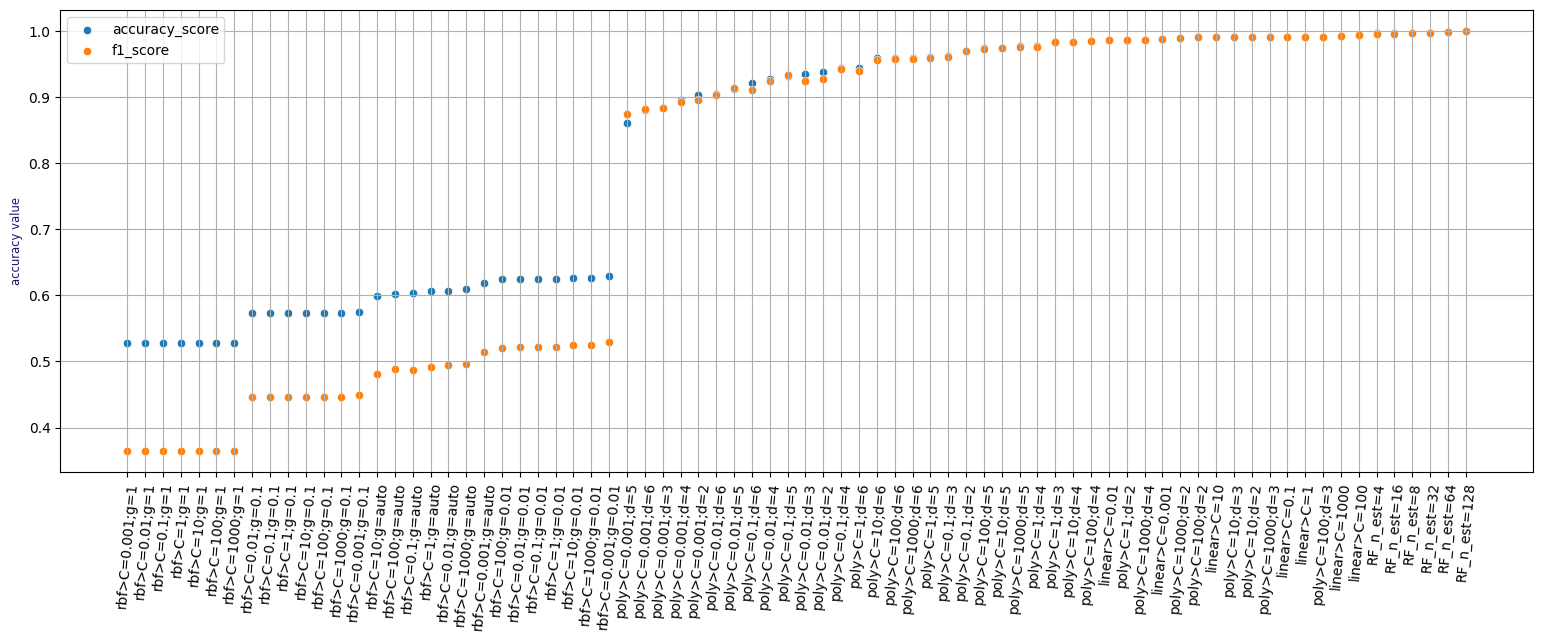

In [115]:
# Порівняння точності за тестовими вибірками для різних моделей
test_results = test_results.sort_values(by=['accuracy_score', 'f1_score'])
show_compare_accuracy_scatter(x=test_results.index, data=test_results)

In [117]:
train_results.iloc[-6:], valid_results.iloc[-6:], test_results.iloc[-6:]

(                   accuracy_score  f1_score
 rbf>C=1;g=0.01                1.0       1.0
 rbf>C=100;g=0.01              1.0       1.0
 rbf>C=1000;g=0.01             1.0       1.0
 RF_n_est=32                   1.0       1.0
 RF_n_est=64                   1.0       1.0
 RF_n_est=128                  1.0       1.0,
               accuracy_score  f1_score
 linear>C=1          0.998124  0.998124
 RF_n_est=8          0.999062  0.999054
 RF_n_est=32         0.999062  0.999054
 RF_n_est=64         0.999062  0.999054
 RF_n_est=128        0.999062  0.999054
 RF_n_est=16         1.000000  1.000000,
               accuracy_score  f1_score
 RF_n_est=4          0.996251  0.996113
 RF_n_est=16         0.996251  0.996113
 RF_n_est=8          0.997188  0.997113
 RF_n_est=32         0.997188  0.997113
 RF_n_est=64         0.998126  0.998126
 RF_n_est=128        1.000000  1.000000)

In [119]:
test_results[test_results['accuracy_score'] >= 0.99].index

Index(['poly>C=100;d=2', 'linear>C=10', 'poly>C=10;d=3', 'poly>C=10;d=2',
       'poly>C=1000;d=3', 'linear>C=0.1', 'linear>C=1', 'poly>C=100;d=3',
       'linear>C=1000', 'linear>C=100', 'RF_n_est=4', 'RF_n_est=16',
       'RF_n_est=8', 'RF_n_est=32', 'RF_n_est=64', 'RF_n_est=128'],
      dtype='object')

In [120]:
train_results.loc['linear>C=1'], valid_results.loc['linear>C=1'], test_results.loc['linear>C=1']

(accuracy_score    0.994456
 f1_score          0.994392
 Name: linear>C=1, dtype: float64,
 accuracy_score    0.998124
 f1_score          0.998124
 Name: linear>C=1, dtype: float64,
 accuracy_score    0.991565
 f1_score          0.991291
 Name: linear>C=1, dtype: float64)

Для запропонованого датасету, враховуючи що використовувався один і той самий апарат та у незмінній орієнтації сталі часові часові відліки, використано моделі з різними алгоритмами (SVC: linear, polynomial, rbf; RandomForestClassifier) та різними налаштуванями. В якості впливаючих ознак обиралося декілька наборів параметрів, розрахованих з оригінальних(початкових) даних.
> Рандомне перемішування даних для вибірок (shuffle=True) може помітно впливати на результати співставлення різних алгоритмів, усереднено - орієнтовно достатня точність.

За першим набором статистичних параметрів виплило, що на всіх вибірках деякі моделі 'rbf' з деякими параметрами (gamma=1) - невикористовувані. <br>
Інші - показали відносно високий результат (> 80%). Параметр gamma=auto для моделей 'rbf' зазвичай кращий, але для деяких вручну заданих параметрів (0.01) може бути значно кращий результат (0.87 проти 0.98) на валідаційних та тестових вибірках. <br>
Орієнтовно зважено (за декільками циклами запуску) можна сказати, що проста лінійна модель 'linear>C=1' дає досить хороші відносні результати на всіх вибірках. 
<br>(train, valid, test):
> (accuracy_score    0.996535<br>
f1_score          0.996483<br>
Name: linear>C=1, dtype: float64,<br>
accuracy_score    0.991557<br>
f1_score          0.991993<br>
Name: linear>C=1, dtype: float64,<br>
accuracy_score    0.989691<br>
f1_score          0.989776<br>
Name: linear>C=1, dtype: float64)
 
 Тому з `36` статистичних параметрів обрано частину (найвагоміші для лінійної `'var_Z', 'max_Y', 'med_Y', 'mean_Z', 'med_Z', 'mean_Y', 'min_Z', 'min_Y'`) та проведено дослідження лише враховуючи їх. (скоріше за все є якась кореляція з параметрами за `X`)<br>
 Результати трохи погіршились майже для всіх моделей, для деяких - майже не змінилась. Швидкість обрахунку зросла в декілька разів, а точність для моделі `linear>C=1` падає не більше ніж декілька `%`.<br>
 Обираючи ознаки (`Time domain features`) з обраних (`42` шт.) в статті  можна помітити, що для даного випадку моделі `'rbf'` показують найгірші результати на валідаційній та тестовій вибірках. <br>
 Загалом тестуючи окремо різні моделі - можна помітити, що достатня кількість дерев для алгоритму `Random Forest` може трохи по різному впливати, але і точність і швидкість прорахунку досить високі (зазвичай найкращі у даному випадку).<br>
 За підсумком усіх результатів можна лише зробити висновок, що для різних досліджуваних явищ (різних датасетів) необхідно підбирати як моделі, так і параметри їх алгоритмів, бо вони можуть помітно впливати на результати; Інколи навіть простих моделей може виявитися достатнім (в залежності від встановлених вимог) як навіть і обрання лише найвагоміших параметрів. Звичайно, за умови невиявлення взаємонезалежних суттєво вагомих ознак - моделі можуть видавати посередні результати, особливо на валідаційних та тестових вибірках. <br>
 